
# Decision Trees    

In the presentation, there is a link to a website, giving a visual intro to decision tree, if this is not working, find here [the html version of the site A-visual-introduction-to-machine-learning-website](DSBOOK/images/decision_tree/A-visual-introduction-to-machine-learning-website.html).

Some pictures in the presentations were self drawn with affinity designer. You can find the vector file (.afdesign) in the DSBOOK/images folder, where all images of this lecture are stored.

## First Part - Necessary Code

The first part of the notebook contains all the necessary imports and function definitions for the plots shown later in the presentation.

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb, ListedColormap
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree
from sklearn.datasets import make_moons
from scipy import ndimage

%matplotlib inline

In [3]:
# Import company colors
with open('plot_colors.json', 'r') as pc:
    color_dict = json.load(pc)

c_light, c_dark, _ = color_dict['color_light'], color_dict['color_dark'], color_dict['color_blue']

# Define color map for plotting
color_map = ListedColormap([c_dark, c_light])

#granite = '#252629'
#nemo = '#FF4A11'

# Define color and random seed
green = "#41992c"
blue = "#104683"
housing_colors = [blue, green]


# Define random seed
RSEED = 42

### Data import and generation

In [4]:
# Housing data for classification
housing_data = pd.read_csv("../data/housing_data.csv")

y_housing = housing_data.target
X_housing = housing_data.drop(['target'], axis=1)

In [5]:
# Half moon data for classification
X_moon, y_moon = make_moons(n_samples=100, noise=0.25, random_state=3)

In [6]:
# Quadratic training set + noise for regression
np.random.seed(42)
m = 200
X_reg = np.random.rand(m, 1)
X_reg = pd.DataFrame(X_reg, columns=["x1"])
y_reg = 4 * (X_reg - 0.5) ** 2
y_reg = y_reg + np.random.randn(m, 1) / 10

### Plotting functions

In [7]:
# Plot elevation feature
def plot_elevation(data):
    housing_data['elevation_bins'] = pd.cut(housing_data['elevation'], 25)

    plt.figure(figsize=(8, 3))
    ax = sns.countplot(x=housing_data.elevation_bins, hue=housing_data.target, palette=[blue, green])

    current_ticks = ax.get_xticks()
    current_labels = [item.get_text() for item in ax.get_xticklabels()]
    new_labels = [int(float(label.split(',')[0].strip('('))) for label in current_labels]
    selected_ticks = current_ticks[::8]
    selected_labels = new_labels[::8]

    ax.set_xticks(selected_ticks)
    ax.set_xticklabels(selected_labels)

    ax.spines[['right', 'top']].set_visible(False)
    ax.set_ylabel("# of houses", fontsize=14)
    ax.set_xlabel("elevation (above sea level)", fontsize=14)

    ax.legend(["New York", "San Francisco"], loc=1)

In [8]:
def plot_decision_tree(decision_tree, X, colors, fig_size=(13, 7), fontsize=14, impurity=False):
    plt.figure(figsize=fig_size)
    artists = tree.plot_tree(decision_tree, feature_names=X.columns.tolist(), fontsize=fontsize, filled=True, impurity=impurity)
    for artist, impurity, value in zip(artists, decision_tree.tree_.impurity, decision_tree.tree_.value):
        # let the max value decide the color; whiten the color depending on impurity (gini)
        r, g, b = to_rgb(colors[np.argmax(value)])
        f = impurity * 2 # for N colors: f = impurity * N/(N-1) if N>1 else 0
        artist.get_bbox_patch().set_facecolor((f + (1-f)*r, f + (1-f)*g, f + (1-f)*b))
        artist.get_bbox_patch().set_edgecolor('black')

In [9]:
# Function for plotting moon data
def plot_tree_partition(X, y, tree, ax=None):
    if ax is None:
        ax = plt.gca()
    eps = X.std() / 2.

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]

    Z = tree.predict(X_grid)
    Z = Z.reshape(X1.shape)
    faces = tree.apply(X_grid)
    faces = faces.reshape(X1.shape)
    border = ndimage.laplace(faces) != 0
    ax.contourf(X1, X2, Z, alpha=0.8, cmap=color_map, levels=[0, .5, 1])
    ax.scatter(X1[border], X2[border], marker='.', s=0.6, c='black')


    ax.plot(X[:, 0][y==0], X[:, 1][y==0], marker='o', c=c_dark, linestyle='', markeredgecolor='lightgrey', markeredgewidth=1, markersize=10)
    ax.plot(X[:, 0][y==1], X[:, 1][y==1], marker='^', c=c_light, linestyle='', markeredgecolor='dimgrey', markeredgewidth=1, markersize=10)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(np.arange(-1.5, 3, 0.5))
    ax.set_yticks(np.arange(-1, 2, 0.5))
    return ax


# Create Plot
def create_plot(X, y, max_depth=1):
    # Fit model
    dec_tree = DecisionTreeClassifier(max_depth=max_depth, random_state=0).fit(X, y)
    
    # Instantiate plot
    fig, axes = plt.subplots(nrows = 1,ncols = 2, figsize = (15,5))

    # Add plot to the right
    tree.plot_tree(dec_tree, ax=axes[1])

    # Add plot to the left
    plot_tree_partition(X, y, dec_tree, ax=axes[0])
    axes[0].set_title(f"Depth = {dec_tree.tree_.max_depth}")
    axes[0].set_xlabel("X₀")
    axes[0].set_ylabel("X₁")

    
# Plot showing effect of regularisation   
def regression_regularisation_tree(X, y, figsize=(13, 4)):
    # Train models
    tree_reg1 = DecisionTreeRegressor(random_state=42).fit(X, y)
    tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10).fit(X, y)
    
    # Make predictions
    x1 = pd.DataFrame(np.linspace(0, 1, 500).reshape(-1, 1), columns=['x1'])
    y_pred1 = tree_reg1.predict(x1)
    y_pred2 = tree_reg2.predict(x1)
    
    fig, ax = plt.subplots(ncols=2, figsize=figsize, sharey=True)
    
    # Plot without regularisation
    ax[0].plot(X, y, ".", color=c_dark)
    ax[0].plot(x1, y_pred1, c_light, linewidth=2, label=r"$\hat{y}$")
    ax[0].axis([0, 1, -0.2, 1.1])
    ax[0].set_xlabel("$x_1$", fontsize=18)
    ax[0].set_ylabel("$y$", fontsize=18, rotation=0)
    ax[0].legend(loc="upper center", fontsize=18)
    ax[0].set_title("No restrictions", fontsize=14)
    
    # Plot with regularisation
    ax[1].plot(X_reg, y_reg, ".", color=c_dark)
    ax[1].plot(x1, y_pred2, c_light, linewidth=3, label=r"$\hat{y}$")
    ax[1].axis([0, 1, -0.2, 1.1])
    ax[1].set_xlabel("$x_1$", fontsize=18)
    ax[1].legend(loc="upper center", fontsize=18)
    ax[1].set_title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

## Second Part - Lecture
Here starts the actual decision tree lecture. 

<div class="slide-title"> 
        
# Decision Trees
    
           
</div> 

## How would you differentiate these animals from one another?
(through their various features)

<img src="../images/decision_tree/img_p1_1.png" style="display:block; margin:auto">

Notes:  
Mention the purpose of DT first: Aim is to classify further animals of which you don't know the label.  
These animals (training dataset) have already been labeled/classified (penguin, hawk, ...). Select whatever features enable you to classify new unknown animals.   
Is this supervised/regression problem or what?

## A Binary Tree
 
<div class="group">
  <div class="text">
Decision trees are based on binary trees:
      
1 Question has 2 answers
      
= 1 Parent node has 2 children nodes
  </div>
  <div class="images">
    <img src="../images/decision_tree/img_p2_1.png">
  </div>
</div>

Notes:  
A pigeon would be classified as a hawk. Why? Model is too simple.

### A Binary Tree
<div class="group">
  <div class="text">
      
First decision split is called **root** or **root node**
      
Each decision node compares a feature:
  * True/False question (for categorical
features)
  * Larger than split (for numerical features)
      
Each **leaf node** (end node) represents a class
label
      
To predict an unknown/new instance, we go through all the
decisions in the tree until we end up at a leaf.
      
  </div>
  <div class="images">
    <img src="../images/decision_tree/img_p3_1.png">
  </div>
</div>

### A Tree is built!

<div class="group">
  <div class="text">
      
Node’s question - which feature and which threshold is appropriate - is chosen during training

This is done recursively until a stop condition is reached (e.g. less than 5 observations in
a node, or node is pure).
      
This is a tree with depth=2.
      
  </div>
  <div class="images">
    <img src="../images/decision_tree/img_p3_1.png">
  </div>
</div>


### If the feature is continuous, decision work just as fine


<div class="group">
  <div class="text">
      
1. The data are ordered in ascending order
2. Each mean between two adjacent data points is considered a splitting point
      
  </div>
  <div class="images">
    <img src="../images/decision_tree/img_p3_1.png">
  </div>
</div>

Notes:  
This is funny: If 2 kg is the mean between the lightest bear and the heaviest goldfish ...

## How to differentiate if a house is located in New York or San Francisco?

In [10]:
housing_data.head(1)

,bath,beds,elevation,price,price_per_sqft,sqft,target,year_built
0,1.0,2.0,10,999000,999,1000,0,1960


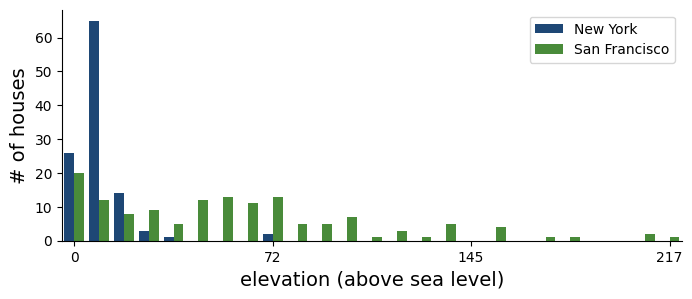

In [11]:
plot_elevation(housing_data)

## Interpreting Decision Tree

* First line of decision node: Feature name and split value

[visual example](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)

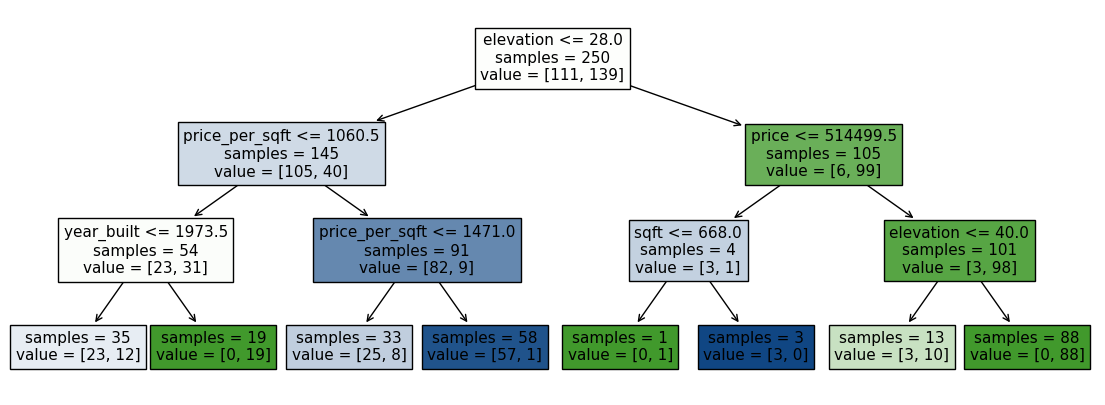

In [11]:
# Train model 
clf_housing_max_depth_3 = DecisionTreeClassifier(max_depth=3, random_state=RSEED)
clf_housing_max_depth_3.fit(X_housing, y_housing)

plot_decision_tree(clf_housing_max_depth_3, X_housing, housing_colors, fig_size=(14, 5), fontsize=11, impurity=False)

Notes:  
Like in a job interview, at which the interview partner judges you according to the first impression you give.

### Interpreting Decision Tree

**samples**: How many observations are in the node <br>
**value**: Target value distribution - Real number of observations per class

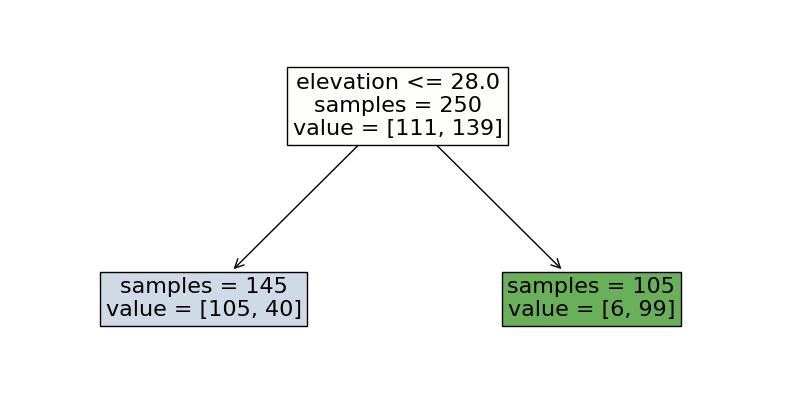

In [12]:
# Train model with max_features=
clf_housing_max_depth_1 = DecisionTreeClassifier(max_depth=1, random_state=RSEED)
clf_housing_max_depth_1.fit(X_housing, y_housing)

plot_decision_tree(clf_housing_max_depth_1, X_housing, housing_colors, fig_size=(10, 5), fontsize=16, impurity=False)

### Interpreting Decision Tree

Is a house located in New York or San Francisco?

* Leaf node → prediction value


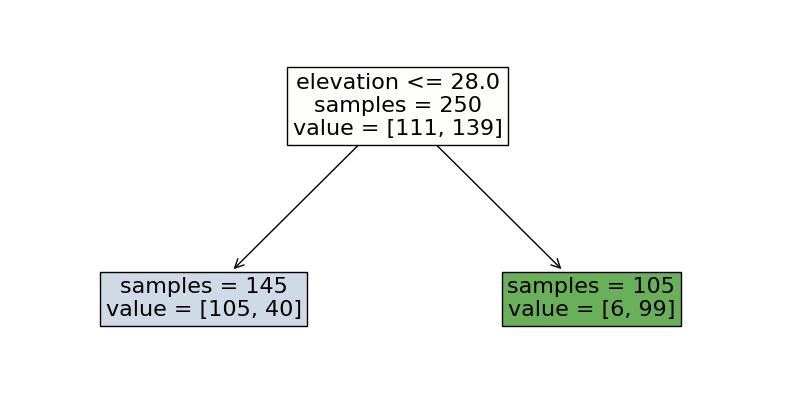

In [13]:
plot_decision_tree(clf_housing_max_depth_1, X_housing, housing_colors, fig_size=(10, 5), fontsize=16, impurity=False)

### Interpreting Decision Tree

<div class="group">
    <div class="text">

→ Confusion matrix based on one split
    </div>
    <div class="text">

| true \ pred   | New York | San Francisco | 
|--------------:|----------|---------------|
| New York      | 105      | 6             |
| San Francisco | 40       | 99            | 

</div>
</div>

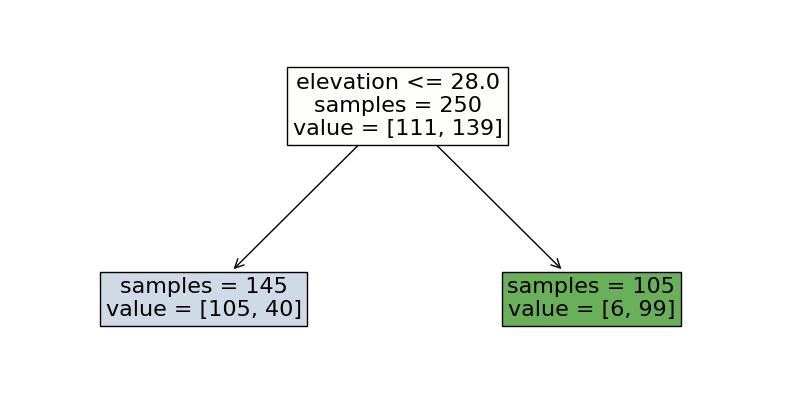

In [14]:
plot_decision_tree(clf_housing_max_depth_1, X_housing, housing_colors, fig_size=(10, 5), fontsize=16, impurity=False)

Notes: In confusion matrix, **r**ows are t**r**ue values and **c**olumns are predi**c**ted values. 

### Interpreting Decision Tree

* Leaf node purity - leaf nodes where one class has an overwhelming majority are more reliable predictors
* Number of samples in leaf node: large leaf nodes are preferable, too few samples in leaves might be a sign of overfitting

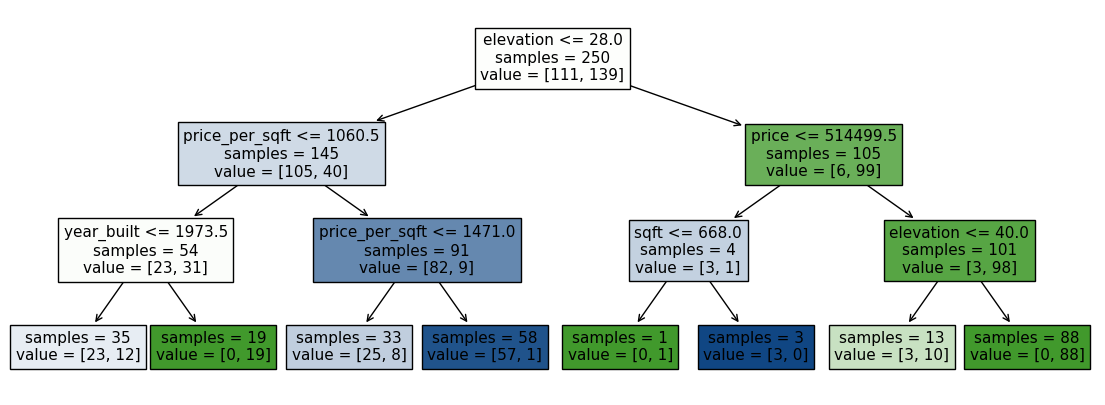

In [15]:
plot_decision_tree(clf_housing_max_depth_3, X_housing, housing_colors, fig_size=(14, 5), fontsize=11, impurity=False)

## Why is it dangerous to grow a large tree?
<center>
    <img src="../images/decision_tree/img_p13_1.png" width=800>
</center>

### Why is it dangerous to grow a large tree?

<div class="group">
  <div class="text">
      
* Nodes will be splitted until leaves are pure
* Decision Trees can be extremely perceptive of the training data
* Tend to overfit the data

[visual example](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
      
  </div>
  <div class="images">
    <img src="../images/decision_tree/img_p13_1.png" width=600>
  </div>
</div>

## Decision Trees in a Nutshell
* Easy to interpret (white box)
* Can be used for regression and classification problems
* No feature scaling or centering needed
* No assumptions needed (e.g. linearity)
* Building block of Random Forests, Ada boost, Gradient boost
* Training is costly, prediction is cheap
* Tend to overfit the data


Notes:  
features can be classes or continuous values. However, the terms regression/classification refer to response variable.

## Break

<center>
<img src="../images/decision_tree/img_p16_1.png" width=600>
</center>

## Splitting Decision

<div class="group">
    <div class="text_70">

Which feature to take first?

Which splitting point to choose?

Decision Trees can be based on different algorithms.

→ We will discuss **Classification and Regression Trees** (CART) by Breiman et al. (1984)    
    </div>
    <div class="images_30">
        <img src="../images/decision_tree/img_p17_1.png">
    </div>
</div>

### Which is the best split?

<div class="group">
  <div class="text">

All leaves are **impure**, i.e. they do not devide the instances into a pure group. 
  </div>
  <div class="images">
    <img src="../images/decision_tree/dec_tree_gini.png" width=600>
  </div>
</div>


## Gini Impurity

<div class="group">
  <div class="text">
In order to build a tree, we measure how pure the data split is.

On of the most common measures is the **[Gini](https://en.wikipedia.org/wiki/Corrado_Gini) impurity**.

Alternatives are misclassification error or entropy.
  </div>
  <div class="images">
    <img src="../images/decision_tree/dec_tree_gini.png" width=600>
  </div>
</div>

### Gini Impurity

* is a measurement of the likelihood of an **incorrect classification** of a new instance of a random variable, if that new instance were **randomly classified according to the distribution of class labels** from the data set

$$ I_{G}(p)\ =\ \sum_{i=1}^{J}\,p_{i}(1\ -\ p_{i})\ =\ 1-\sum_{i=1}^{J}\,p_{i}^{2}$$

Notes:  More simple: How likely will a new unknown observation be classified incorreclty by the DT.

### Intuition of Gini Impurity

$$I_{G}(p)\ =\ \sum_{i=1}^{J}\,p_{i}(1\ -\ p_{i})\ =\ 1-\sum_{i=1}^{J}\,p_{i}^{2}$$

<img src="../images/decision_tree/gini_impurity_1.png" style="display:block; margin:auto">

$$I_{G}(p)=1-\color{#41992c}{\left(\frac{3}{10}\right)^2}-\color{#104683}{\left(\frac{7}{10}\right)^2}=0.42$$

### Intuition of Gini Impurity

<center>
<img src="../images/decision_tree/gini_impurity_5.png">
</center>


<div class="group">
  <div class="text">
      
$$\begin{align}
I_{G}(p)&=1-\color{#41992c}{\left(\frac{0}{10}\right)^2}-\color{#104683}{\left(\frac{10}{10}\right)^2}=0.0 \\
I_{G}(p)&=1-\color{#41992c}{\left(\frac{3}{10}\right)^2}-\color{#104683}{\left(\frac{7}{10}\right)^2}=0.42
\end{align}$$
      
  </div>
  <div class="text">

$$\begin{align}
I_{G}(p)&=1-\color{#41992c}{\left(\frac{10}{10}\right)^2}-\color{#104683}{\left(\frac{0}{10}\right)^2}=0.0 \\
I_{G}(p)&=1-\color{#41992c}{\left(\frac{7}{10}\right)^2}-\color{#104683}{\left(\frac{3}{10}\right)^2}=0.42
\end{align}$$
      
  </div>
</div>

$$I_{G}(p)=1-\color{#41992c}{\left(\frac{5}{10}\right)^2}-\color{#104683}{\left(\frac{5}{10}\right)^2}=0.5$$

### 1. Gini impurity for each node

<div class="group">
  <div class="text">

$$ 1\,-\,\left(\frac{111}{250}\right)^{2}-\left(\frac{139}{250}\right)^{2}=\,0.494$$

  </div>
  <div class="text">

$$\begin{align}
1-\left(\frac{105}{145}\right)^{2}-\left(\frac{40}{145}\right)^{2}\,&=\,0.4  \\
1-\left(\frac{6}{105}\right)^{2}-\left(\frac{99}{105}\right)^{2}\,&=\,0.108
\end{align}$$

  </div>
</div>

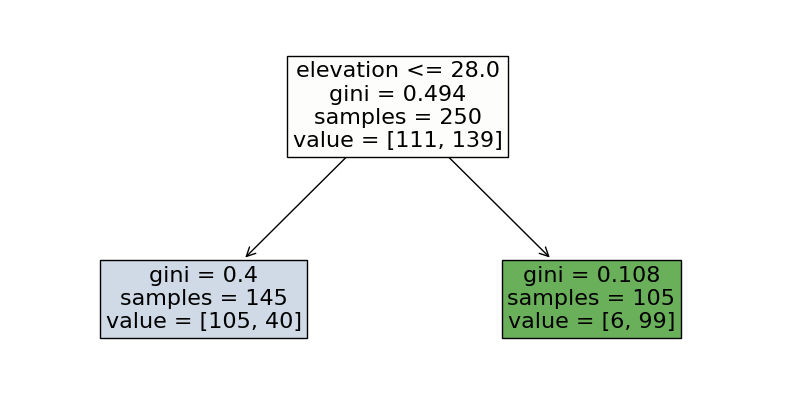

In [16]:
plot_decision_tree(clf_housing_max_depth_1, X_housing, housing_colors, fig_size=(10, 5), fontsize=16, impurity=True)

### 2. How well does the split perform overall?

Just calculate the **average of the impurities** of the leaves, of course weighted by their impact (= rel. number of obs.):

$$ 0.4\ \cdot{\frac{145}{250}}+\ 0.108\ \cdot{\frac{105}{250}}=\;0.277$$


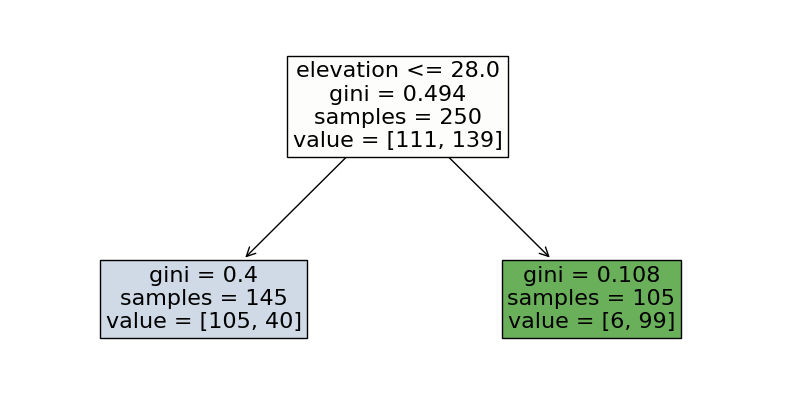

In [17]:
plot_decision_tree(clf_housing_max_depth_1, X_housing, housing_colors, fig_size=(10, 5), fontsize=16, impurity=True)

### Which is the best split?

<div class="group">
  <div class="text">
Let's calculate the Gini impurity for each possible split.

$ I_{G}(p)\ =\ \sum_{i=1}^{J}\,p_{i}(1\ -\ p_{i})\ =\ 1-\sum_{i=1}^{J}\,p_{i}^{2}$
      
Gini impurity of the split is the **weighted average of the impurities** of the leaves.
      
  </div>
  <div class="images">
    <img src="../images/decision_tree/dec_tree_gini.png">
  </div>
</div>

### Which is the best split?

<div class="group">
  <div class="text">
Let's calculate the Gini impurity for each possible split.

$ I_{G}(p)\ =\ \sum_{i=1}^{J}\,p_{i}(1\ -\ p_{i})\ =\ 1-\sum_{i=1}^{J}\,p_{i}^{2}$
      
Gini impurity of the split is the **weighted average of the impurities** of the leaves.

Finally, the best splitting point is the one, which **minimizes the Gini Impurity of the split**. 
      
  </div>
  <div class="images">
    <img src="../images/decision_tree/dec_tree_gini_values.png">
  </div>
</div>

Notes:  algorithm considers all features and all thresholds to select the best purity.  
Only one split is considered for this, called **greedy** algorithm. Regularization might overcome the inferiority of greediness.

## Break

<center>
<img src="../images/decision_tree/img_p16_1.png" width=600>
</center>

Notes: 
Next section covers regression trees and regularisation

## Tree build with two continous features

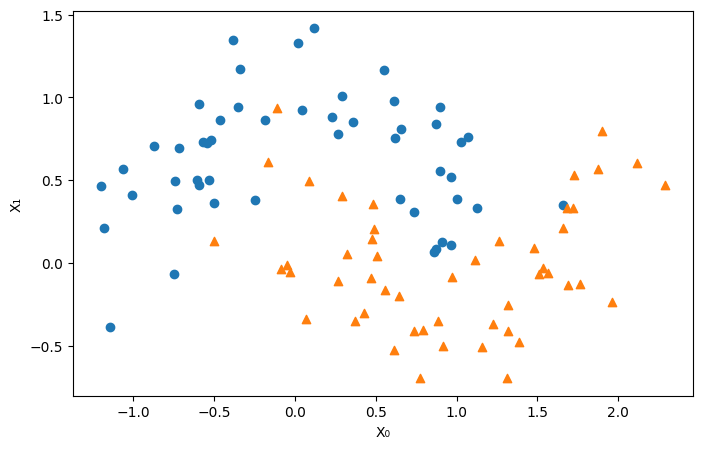

In [41]:
fig, ax = plt.subplots(figsize=(8, 5))
_ = plt.scatter(X_moon[y_moon==0, 0], X_moon[y_moon==0, 1], marker='o')
_ = plt.scatter(X_moon[y_moon==1, 0], X_moon[y_moon==1, 1], marker='^')
_ = ax.set_xlabel("X₀")
_ = ax.set_ylabel("X₁")


Notes: guess the best split for the root node.  
Non-parallel or non-linear separations can be done with SVM, e.g. but not with DT.

## Tree build with two continous features

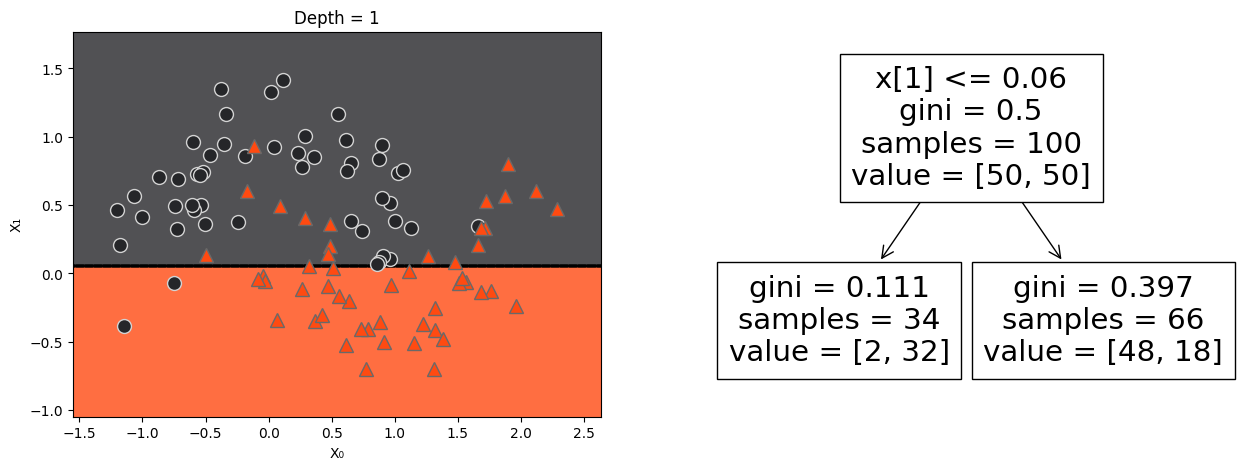

In [18]:
create_plot(X_moon, y_moon, 1)

### The second split

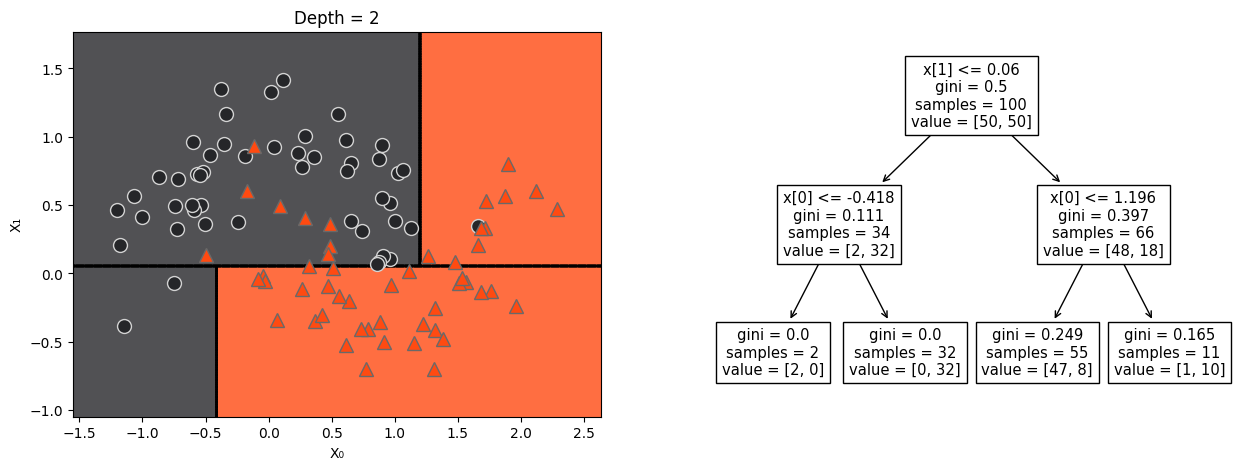

In [19]:
create_plot(X_moon, y_moon, 2)

### Growing a full tree

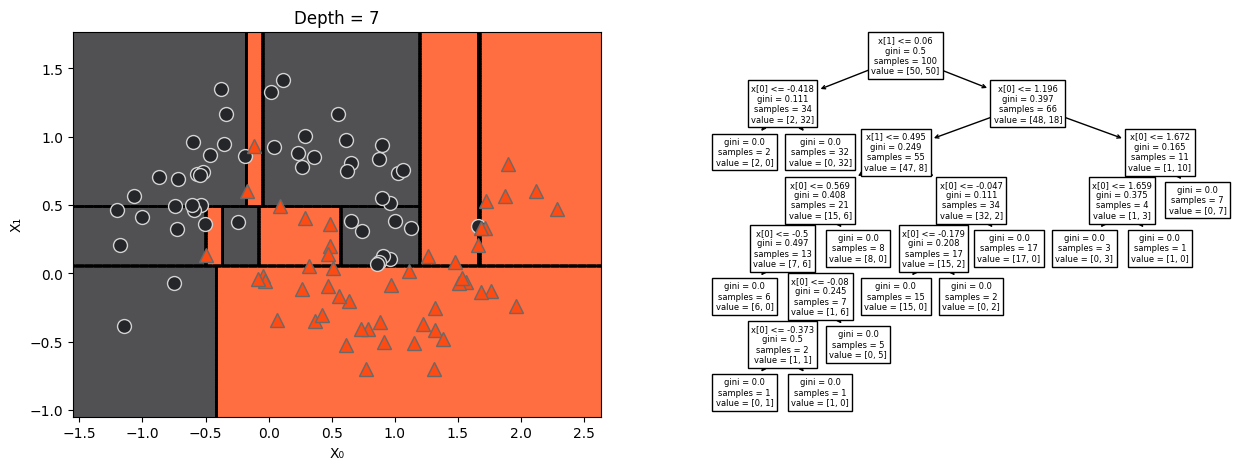

In [20]:
create_plot(X_moon, y_moon, 7)

## Regression Trees

* Similar approach as with classification trees, but split data based on **MSE** not impurity
* Traverse tree to get predicitons for new instance, which is **mean** of target values of all observations in one leaf

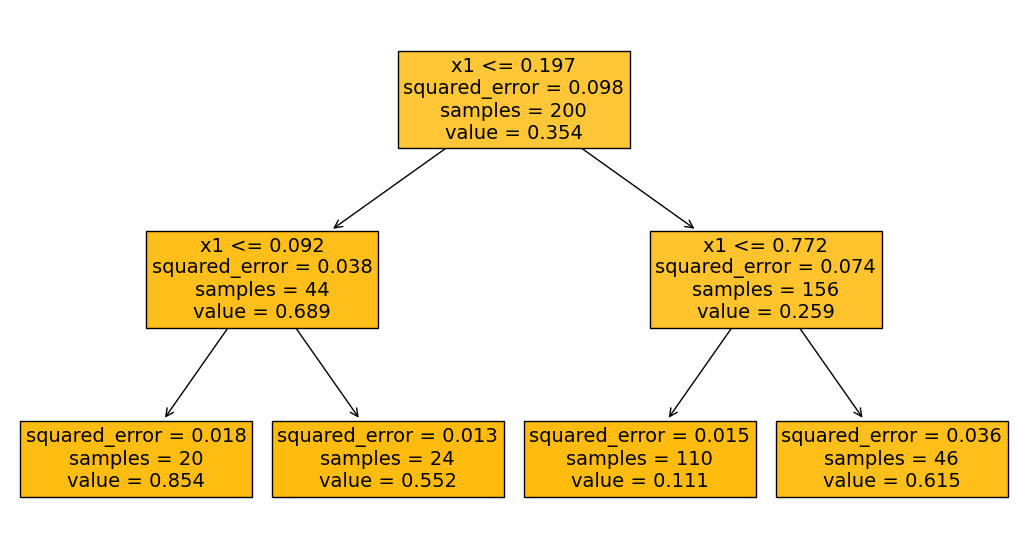

In [21]:
# Train model with max_leaves=6
reg_tree = DecisionTreeRegressor(max_depth=2, random_state=RSEED).fit(X_reg, y_reg)
plot_decision_tree(reg_tree, X_reg, ["#FFBA08"], fig_size=(13, 7), fontsize=14, impurity=True)

## Regularisation is needed!

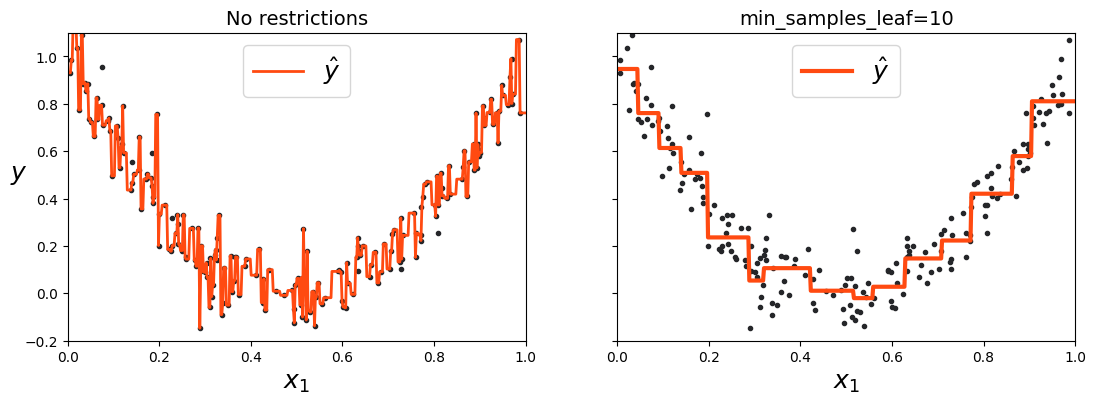

In [22]:
regression_regularisation_tree(X_reg, y_reg)

### Regularisation

<div class="group">
  <div class="text">
      
Decision Trees will recursively split the data until nodes are pure no matter how small the sample size will be.
      
→ High chance of **overfitting.**
    
**Solution:**
      
Pruning Trees → limiting the number of branches/leaves
      
  </div>
  <div class="images">
    <img src="../images/decision_tree/img_p13_1.png" width=600>
  </div>
</div>

### Pruning Trees - `max_leaf_nodes`

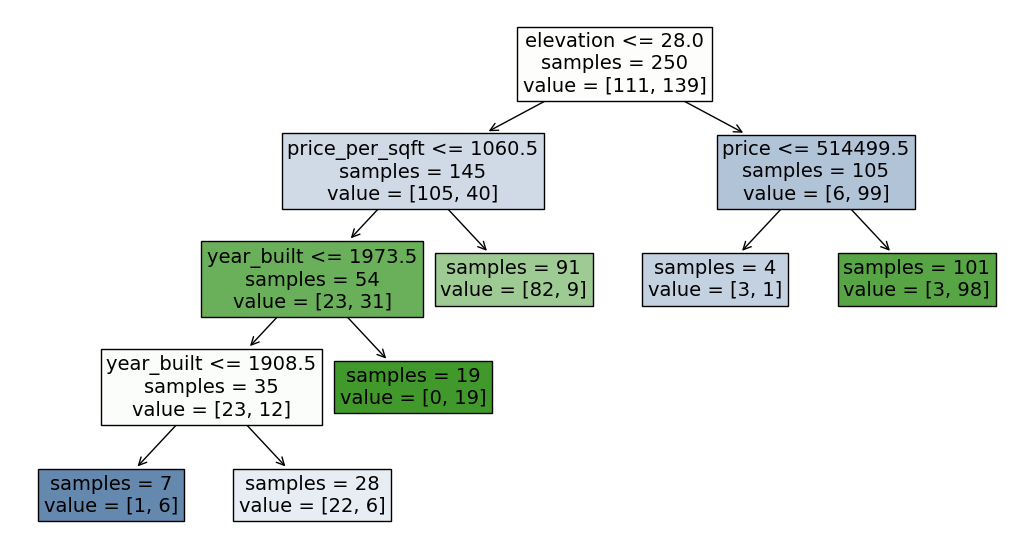

In [23]:
# Train model with max_leaves=6
clf_depth_max_leave_6 = DecisionTreeClassifier(max_leaf_nodes=6, random_state=RSEED)
clf_depth_max_leave_6.fit(X_housing, y_housing)

plot_decision_tree(clf_depth_max_leave_6, X_housing, housing_colors, fig_size=(13, 7), fontsize=14, impurity=False)

Notes:  The total number of leaf nodes must not be larger than 6, e.g.

### Pruning Trees - `max_depth`

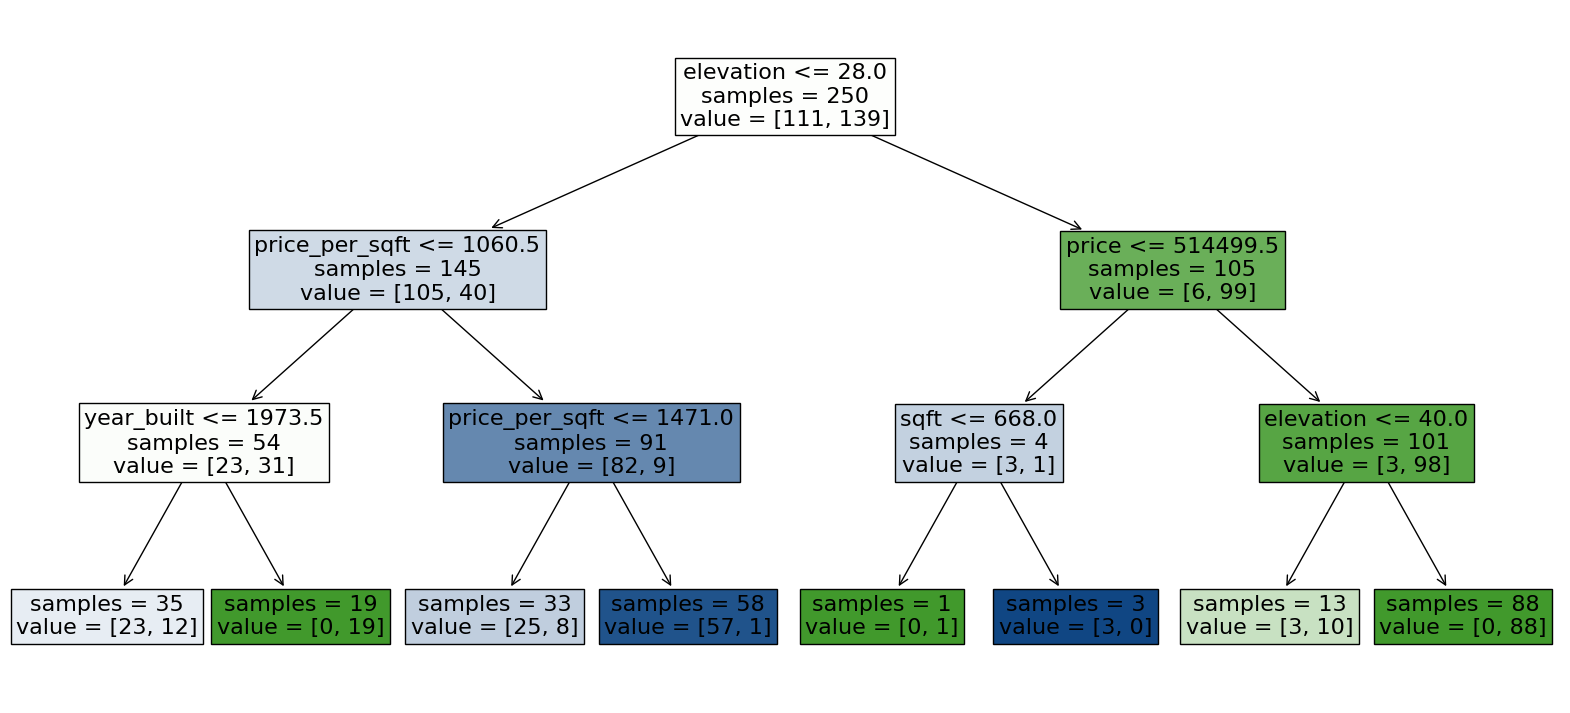

In [24]:
# Train model with max_depth=3
clf_depth_max_depth_3 = DecisionTreeClassifier(max_depth=3, random_state=RSEED)
clf_depth_max_depth_3.fit(X_housing, y_housing)

plot_decision_tree(clf_depth_max_depth_3, X_housing, housing_colors, fig_size=(20, 9), fontsize=16, impurity=False)

Notes: e.g. 3 for this tree

### Pruning Trees - `min_samples_split`

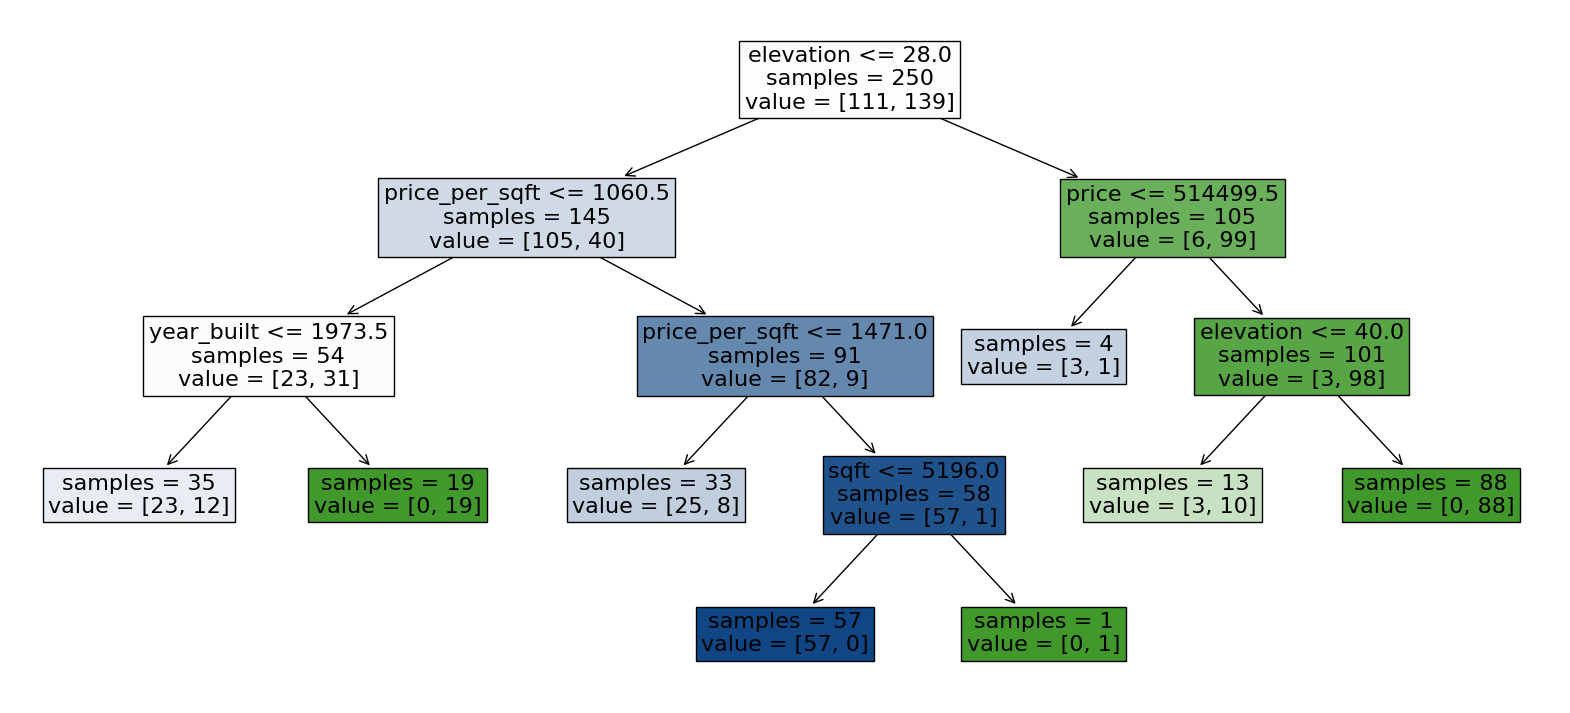

In [25]:
# Train model with max_depth=3
clf_min_samples_split = DecisionTreeClassifier(min_samples_split=50, random_state=RSEED)
clf_min_samples_split.fit(X_housing, y_housing)

plot_decision_tree(clf_min_samples_split, X_housing, housing_colors, fig_size=(20, 9), fontsize=16, impurity=False)

Notes: A node must not be split in case it has too few observations left (set to 50 in this example).

### Pruning Trees - `max_features` 

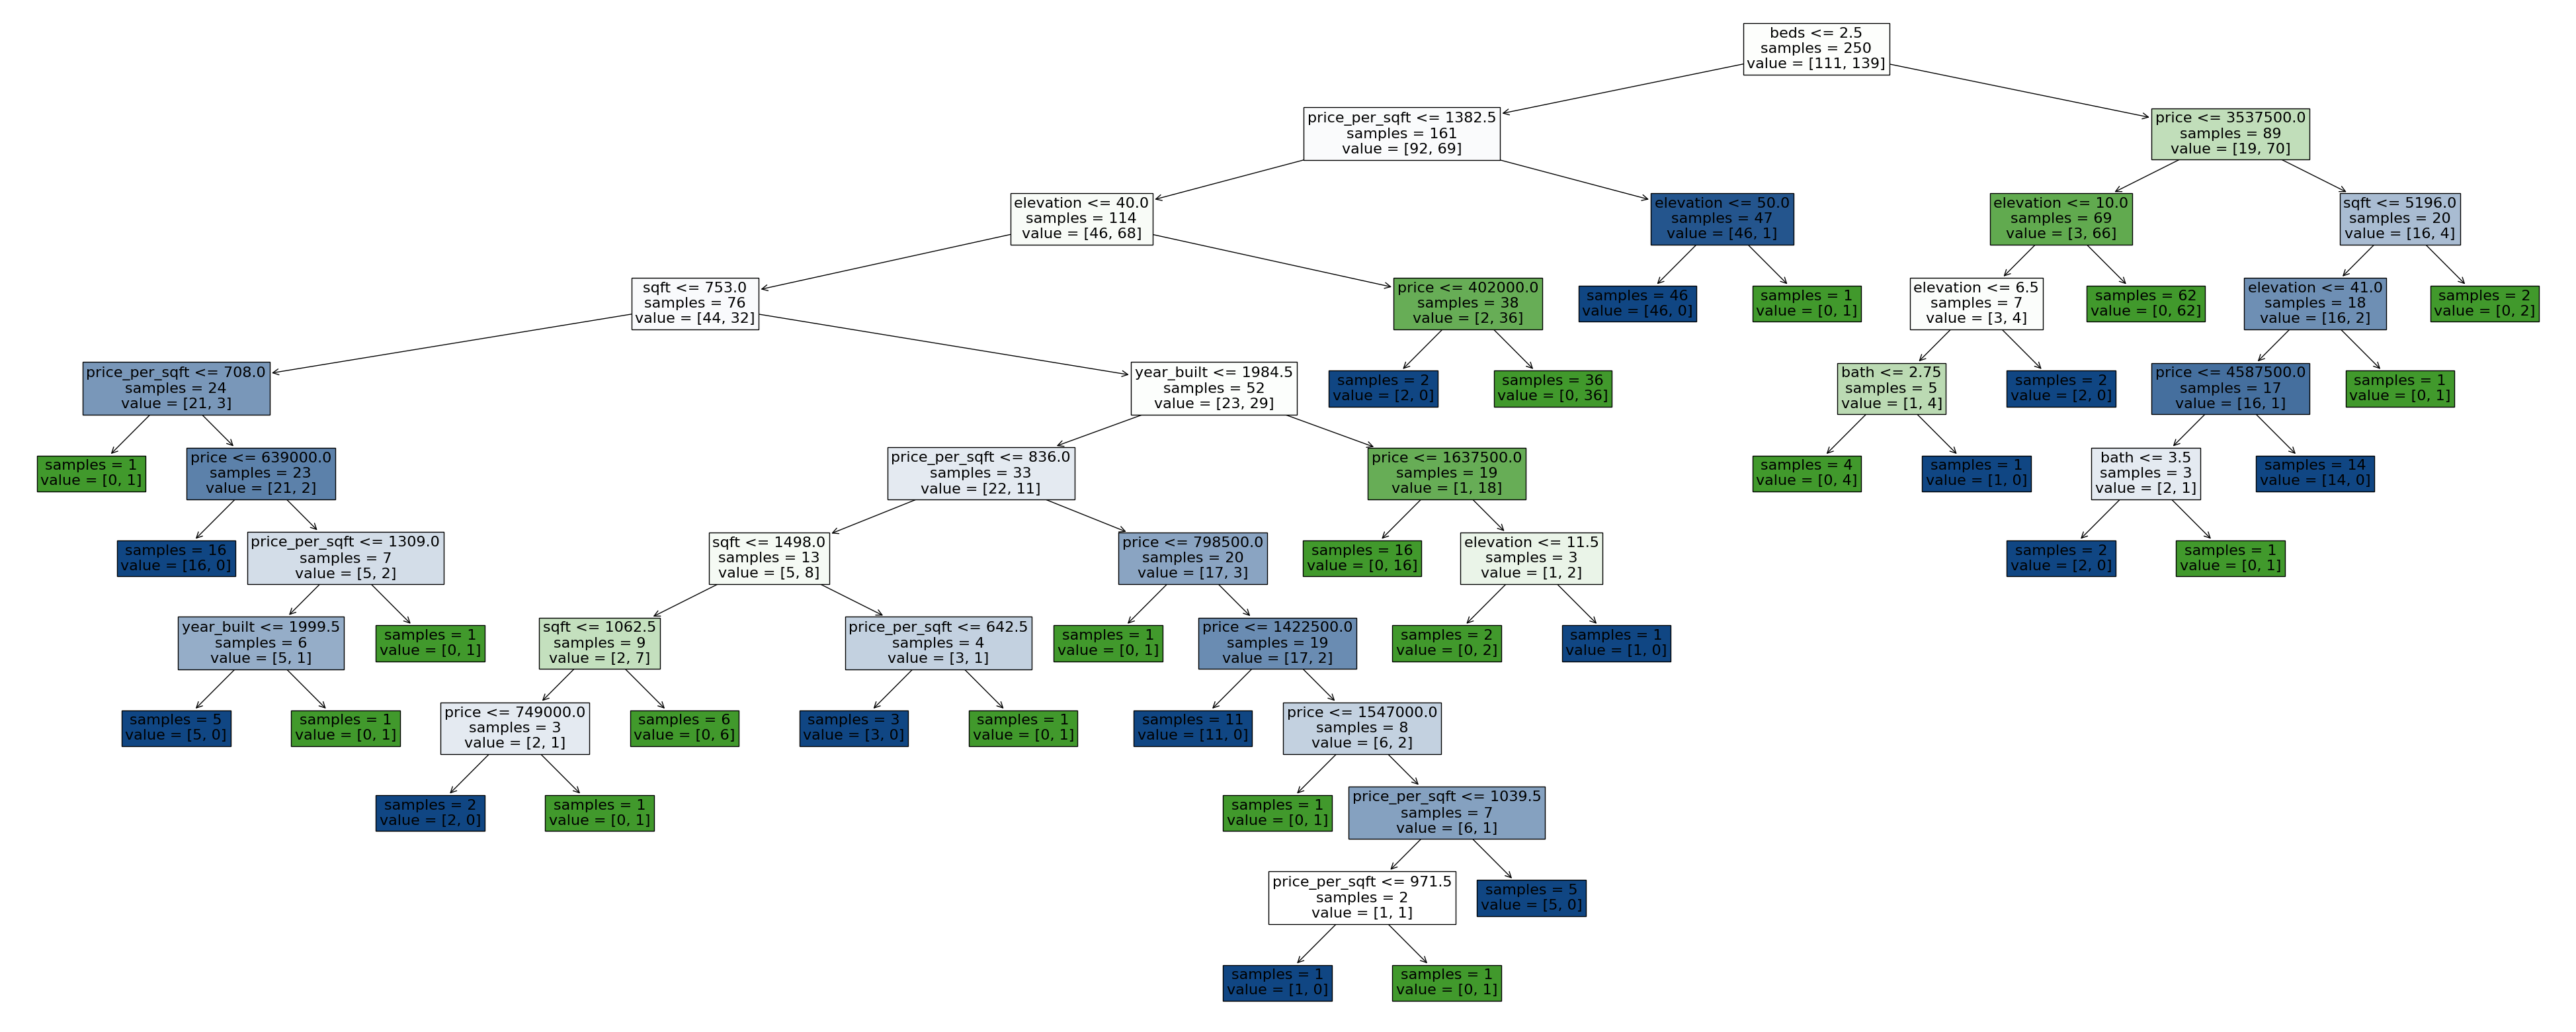

In [26]:
# Train model with max_features=
clf_max_features = DecisionTreeClassifier(max_features=4, random_state=RSEED)
clf_max_features.fit(X_housing, y_housing)

plot_decision_tree(clf_max_features, X_housing, housing_colors, fig_size=(50, 20), fontsize=16, impurity=False)

Notes: Set the max. number of features available for the tree even if there are more features available in the data.

## References

Code for plots:

[Hands on ML repo](https://github.com/ageron/handson-ml2/blob/master/06_decision_trees.ipynb), A. Geron

[Introduction to Machine Learning with Python repo](https://github.com/amueller/introduction_to_ml_with_python/blob/master/02-supervised-learning.ipynb), A. Müller and S. Guido